In [1]:
import numpy as np
import cv2
import os
import pickle as pkl
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

In [2]:
def get_bbox_arr(xml_f, ref_arr):
    root = ET.parse(xml_f).getroot()
    result = np.zeros_like(ref_arr, dtype=int)
    for obj in root.findall("object/bndbox"):
        xmin = int(obj.find("xmin").text)
        xmin = np.clip(xmin - 88, 0, 1023)
        xmax = int(obj.find("xmax").text)
        xmax = np.clip(xmax - 88, 0, 1023)
        ymin = int(obj.find("ymin").text)
        ymin = np.clip(ymin - 88, 0, 1023)
        ymax = int(obj.find("ymax").text)
        ymax = np.clip(ymax - 88, 0, 1023)
        result[ymin:ymax, xmin:xmax] = 1
    return result

def bbox_ROC(root_dir, bbox_dir):
    gather_uncertainty = []
    gather_bbox = []

    for bbox_f in os.listdir(bbox_dir):
    #for uncer_f in os.listdir(root_dir):
        #if not uncer_f.startswith("uncertainty"):
        #    continue
        id = bbox_f.split(".")[0]
        uncer_f = f"uncertainty_{id}.png.npy"
        uncer_arr = np.load(os.path.join(root_dir, uncer_f))[0, :, :].astype(float)
        bbox_f = os.path.join(bbox_dir, bbox_f)
        bbox_arr = get_bbox_arr(bbox_f, uncer_arr)
        gather_uncertainty.append(uncer_arr.reshape(-1))
        gather_bbox.append(bbox_arr.reshape(-1))

    gather_uncertainty = np.concatenate(gather_uncertainty, axis=0)
    gather_bbox = np.concatenate(gather_bbox, axis=0)
    # sort by uncertainty
    sort_idx = np.argsort(gather_uncertainty)[::-1]
    gather_uncertainty = gather_uncertainty[sort_idx]
    gather_bbox = gather_bbox[sort_idx]

    prec, recall = [], []
    TP = np.cumsum(gather_bbox)
    FP = np.cumsum(1 - gather_bbox)
    FPR = FP / (1 - gather_bbox).sum()
    TPR = TP / gather_bbox.sum()

    return FPR[::10], TPR[::10]

def avg_uncertainty(root_dir):
    gather_uncertainty = []
    for uncer_f in os.listdir(root_dir):
        if not uncer_f.startswith("uncertainty"):
            continue
        uncer_arr = np.load(os.path.join(root_dir, uncer_f))[0, :, :].astype(float)
        gather_uncertainty.append(uncer_arr.reshape(-1))
    return np.mean(gather_uncertainty)

38797312
38797312
38797312
38797312
38797312
38797312
38797312


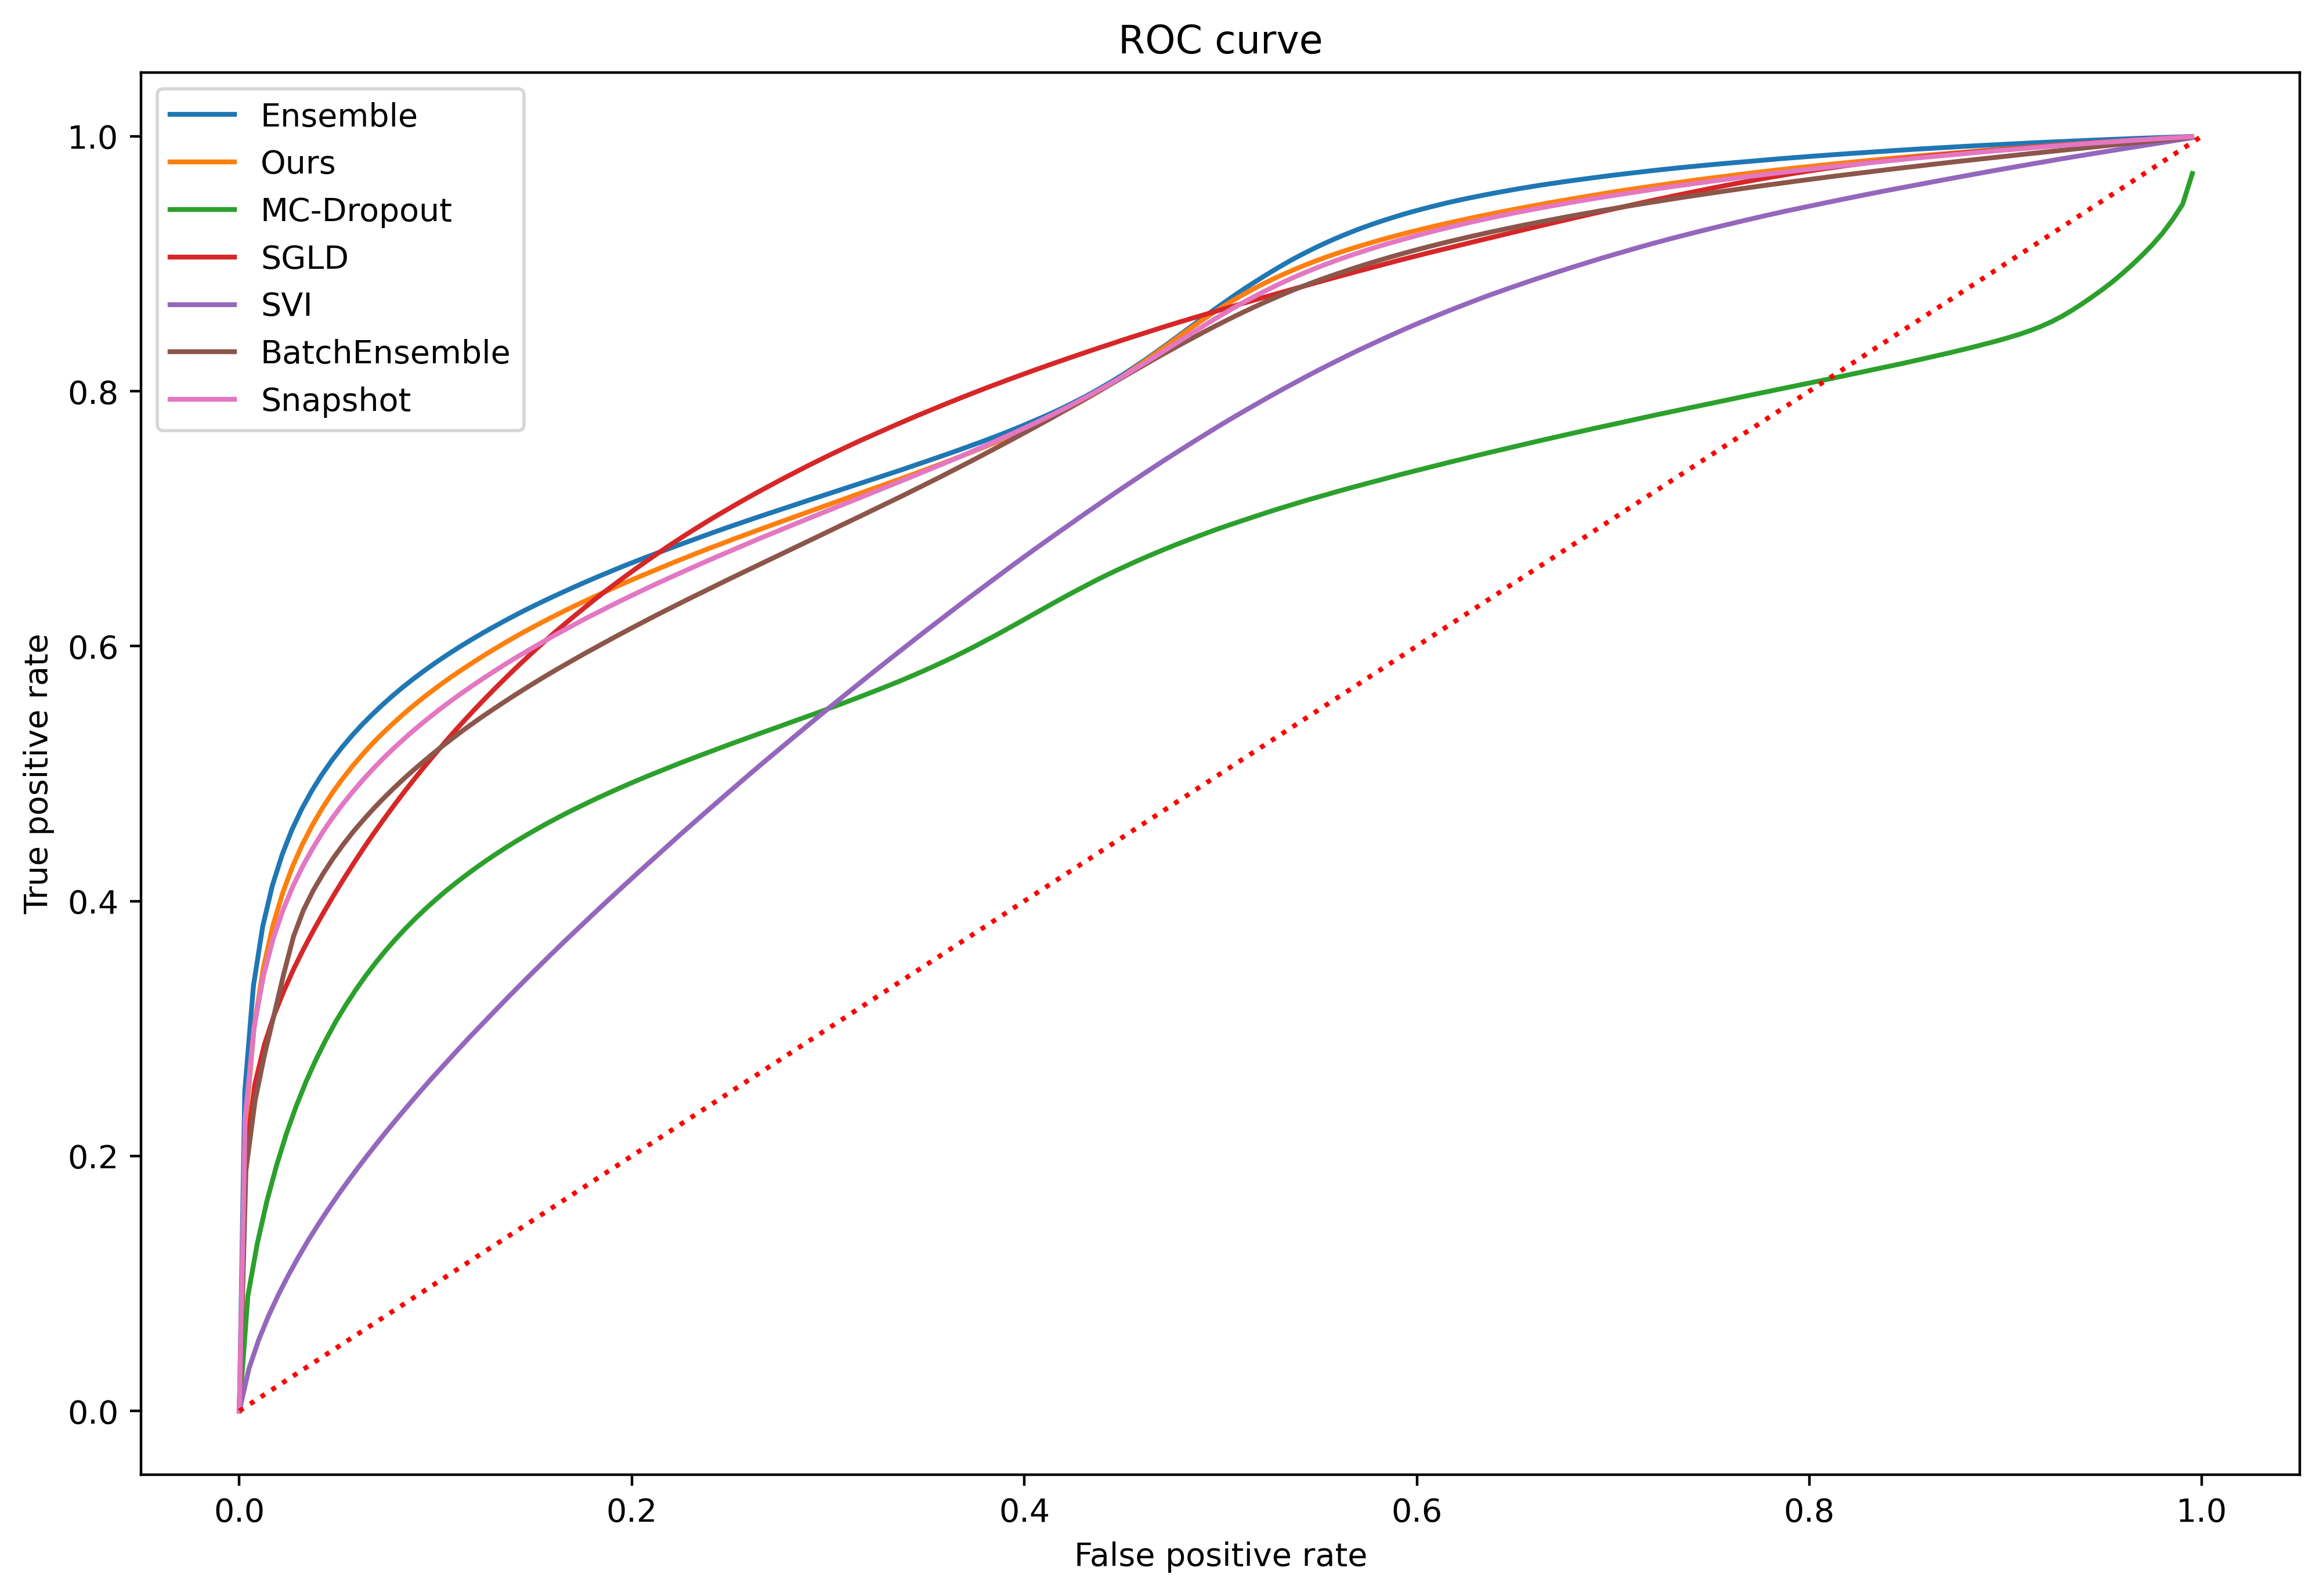

In [4]:
root_dirs = [
    "../results/ensemble_cd105_Enza_patch/",
    "../results/ensemble_local_cd105_Enza_patch/",
    "../results/mcdropout_cd105_Enza_patch/",
    "../results/sgld_cd105_Enza_patch/",
    "../results/svi_cd105_Enza_patch/",
    "../results/batchensemble_cd105_Enza_patch/",
    "../results/snapshot_cd105_Enza_patch/",
    #"../results/ensemble_Enza_patch_bbox_test_model16/",
]
labels = [
    "Ensemble",
    "Ours",
    "MC-Dropout",
    "SGLD",
    "SVI",
    "BatchEnsemble",
    "Snapshot",
]
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 400
bbox_dir = "../datasets/cd105_Enza_patch/bbox/"
data = {}
for label, root_dir in zip(labels, root_dirs):
    FPR, TPR = bbox_ROC(root_dir, bbox_dir)
    print(len(FPR))
    plt.plot(FPR[::200000], TPR[::200000], label=label)
    data[label] = (FPR, TPR)
plt.plot([0, 1], [0, 1], "r:")
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
with open("./cd105_impurities.pkl", "wb") as writer:
    pkl.dump(data, writer)


In [12]:
root_dirs = [
    "../results/ensemble_excitation_2.4/",
    "../results/ensemble_excitation_4.7/",
    "../results/ensemble_excitation_9.8/",
    "../results/ensemble_excitation_20.4/",
    "../results/ensemble_excitation_30.2/",
    "../results/ensemble_excitation_40.8/",
    "../results/ensemble_excitation_60.4/",
    "../results/ensemble_excitation_80.8/",
    "../results/ensemble_excitation_100/",
]

for root_dir in root_dirs:
    print(avg_uncertainty(root_dir))

0.03321261274042733
0.020741701161599947
0.021326015960151126
0.0322283119278253
0.0640153093853727
0.058320513338666835
0.0244220718331605
0.011180076494917139
0.010014975244037017


In [21]:
uncer = np.load("../results/snapshot_cd105_impurities/uncertainty_test_1.png.npy")
#uncer = ((uncer - np.min(uncer)) / (np.max(uncer) - np.min(uncer)) * 255).astype(np.uint8)
#plt.imshow(uncer[0], cmap=plt.get_cmap('gray'), vmin=0, vmax=255)

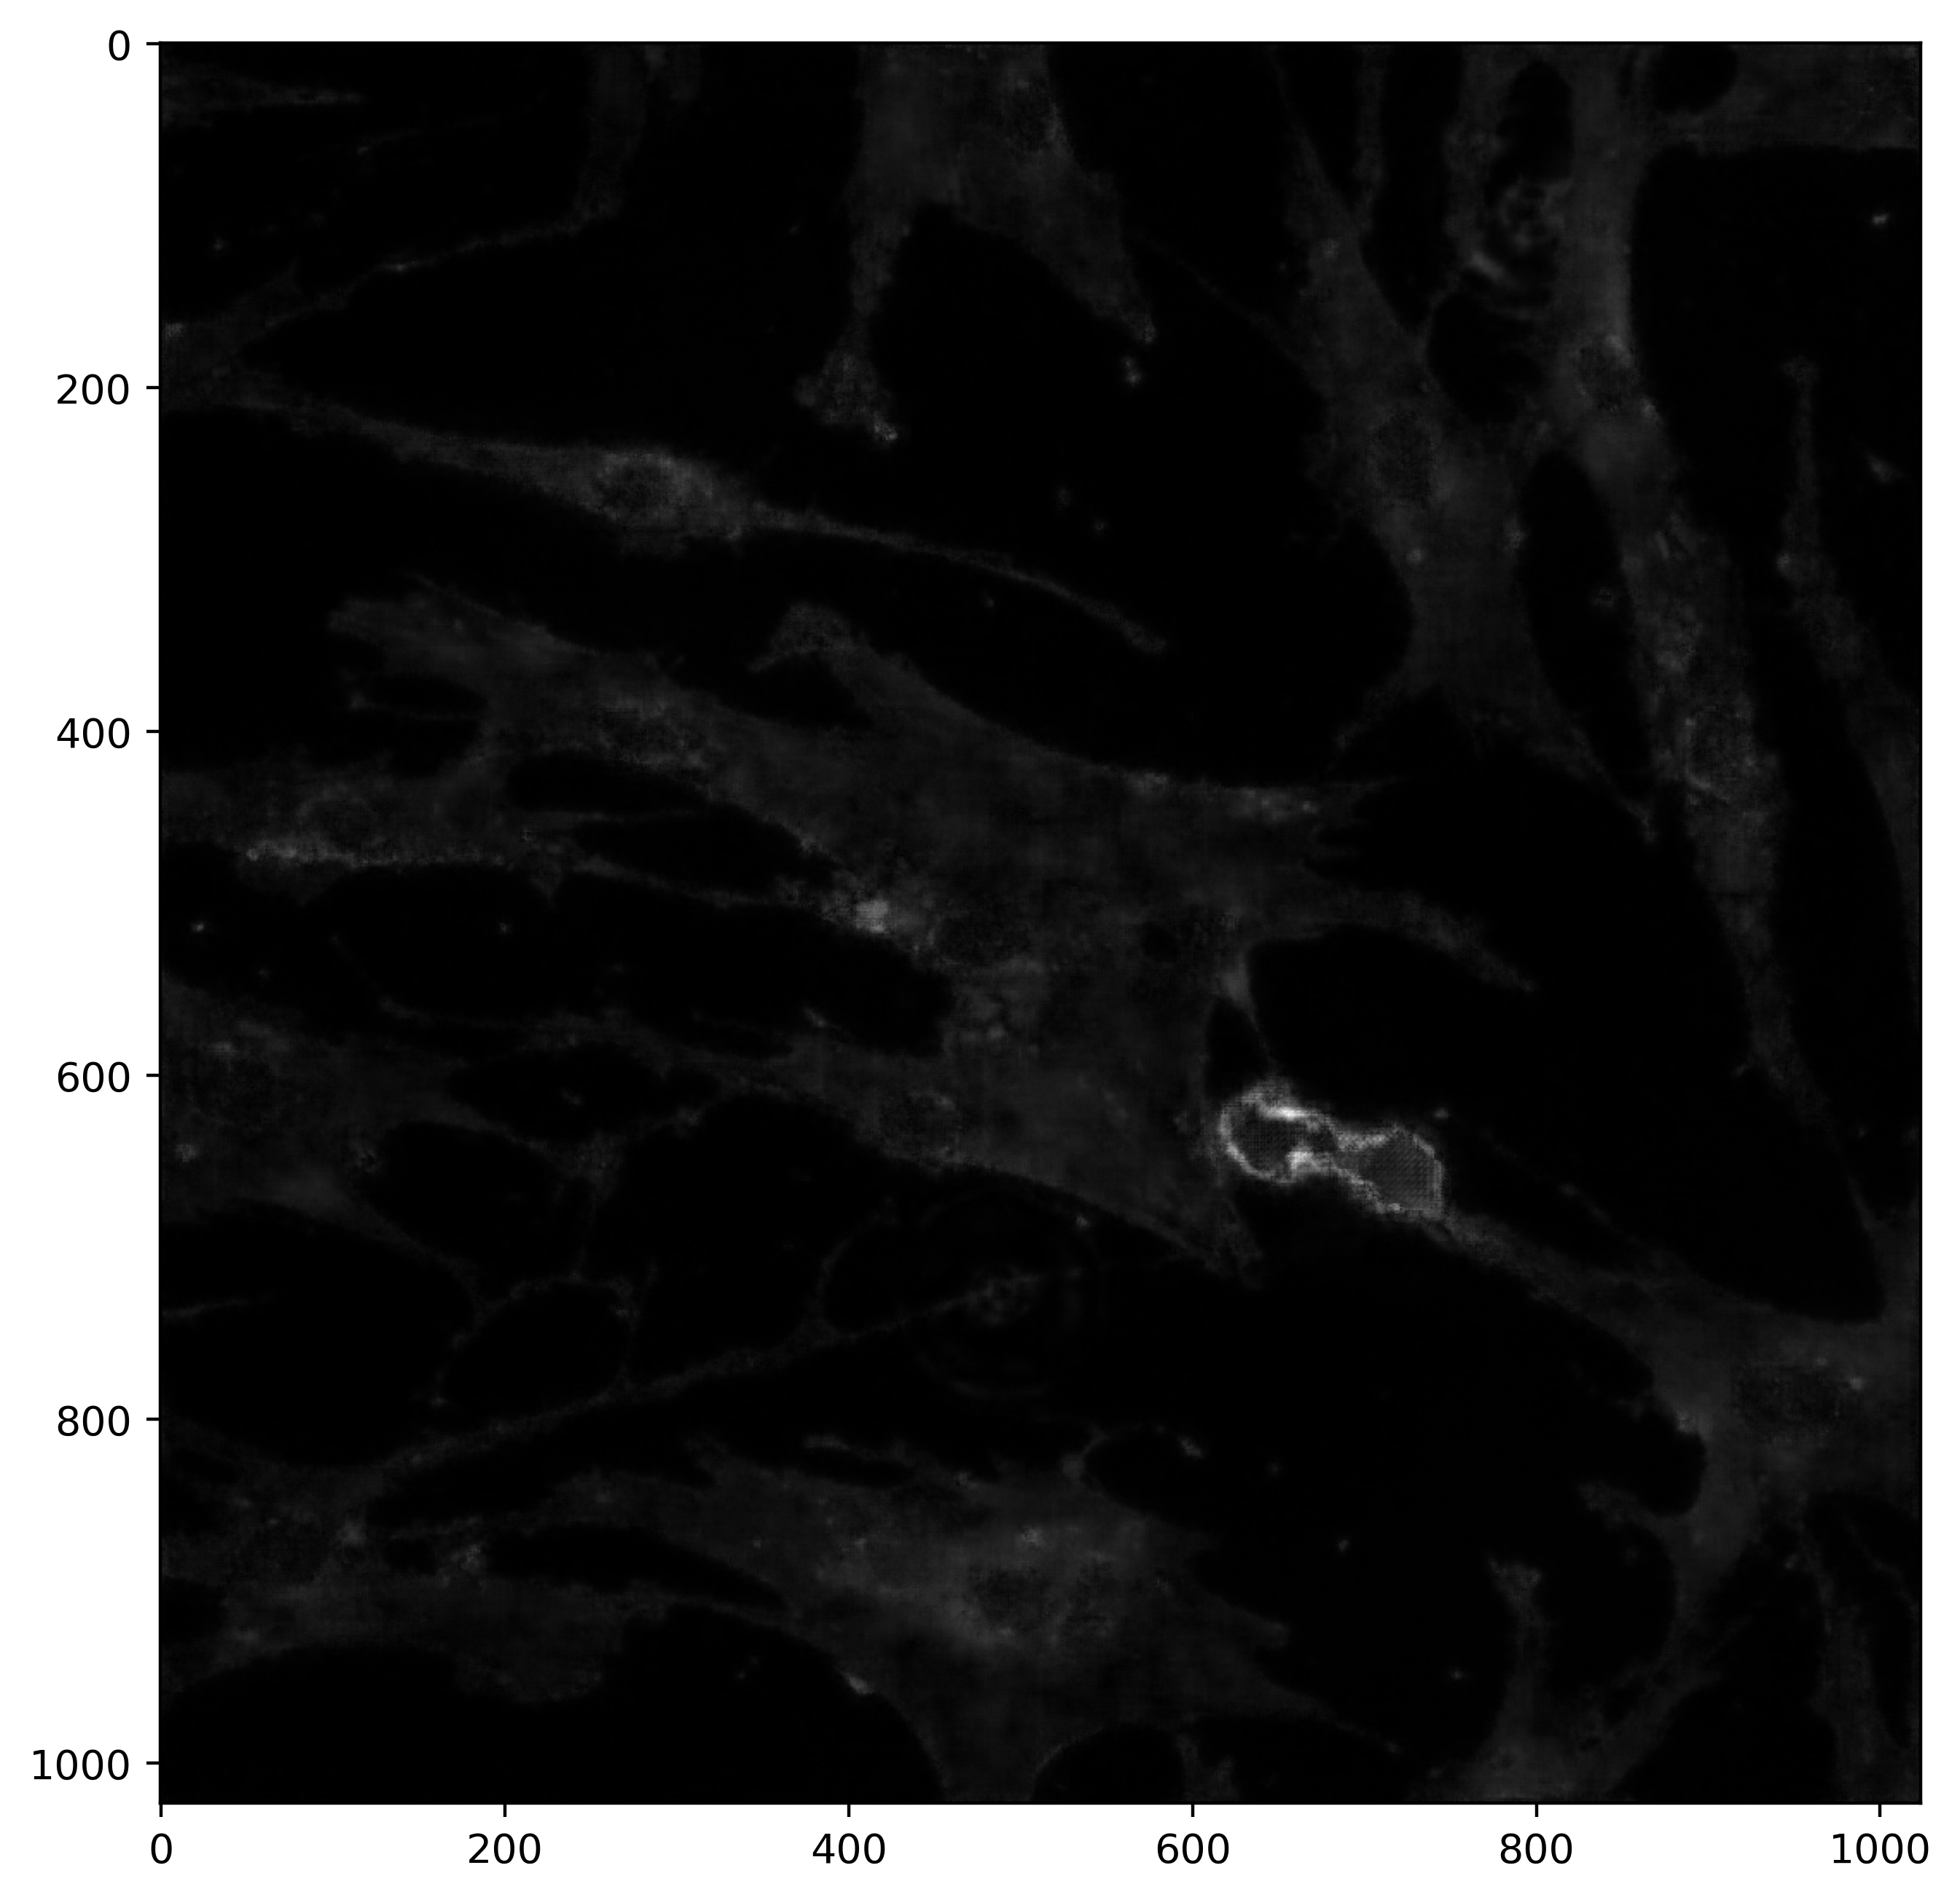

In [19]:
uncer = np.load("../results/ensemble_cd105_impurities/uncertainty_test_1.png.npy")
uncer = ((uncer - np.min(uncer)) / (np.max(uncer) - np.min(uncer)) * 255).astype(np.uint8)
plt.imshow(uncer[0], cmap=plt.get_cmap('gray'), vmin=0, vmax=255)

In [17]:
uncer

array([[[50, 13, 14, ..., 25, 27, 19],
        [13,  8,  8, ..., 15, 15, 27],
        [22,  9,  9, ..., 17, 15, 40],
        ...,
        [ 8,  2,  2, ..., 24, 19, 28],
        [17,  4,  2, ..., 23, 14, 16],
        [37, 10,  6, ..., 18, 21, 29]]], dtype=uint8)

In [22]:
uncer

array([[[0.1302081 , 0.16087861, 0.15729265, ..., 0.12979849,
         0.12894802, 0.09832294],
        [0.16254535, 0.16917728, 0.16934811, ..., 0.13691303,
         0.14426678, 0.12341242],
        [0.1584661 , 0.16836272, 0.17126665, ..., 0.12852751,
         0.13420802, 0.12039768],
        ...,
        [0.16521591, 0.17571336, 0.17491841, ..., 0.15096584,
         0.15295343, 0.13012829],
        [0.16781981, 0.17660674, 0.17420071, ..., 0.15539689,
         0.15172213, 0.13674118],
        [0.13914528, 0.16813539, 0.1694421 , ..., 0.14152458,
         0.14688858, 0.10458446]]])